In [41]:
import torch
import torch.nn as nn
import joblib
import anndata as ad
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class RegressionMLP(nn.Module):
    def __init__(self,):
        super().__init__()
        # Example architecture: 1280 -> 512 -> 256 -> 128 -> 1
        self.model = nn.Sequential(
            nn.Linear(1280, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [3]:
model_baseline_mean_path = '../../data/models/baselines/mean_pear_corr_min_max.joblib'
model_baseline_linreg_path = '../../data/models/baselines/linreg_raw-pear_corr_min_max.joblib'
model_mlp_path = '../../data/models/mlp/pear_corr_min_max_mlp.pt'

anndata_path = '../../data/downstream/secondary_structure.h5ad'

ground_truth_reliability = 'ground_truth_reliability_ssp.parquet'

In [4]:
adata = ad.read_h5ad(anndata_path)
adata.obs.index = adata.obs.index.str.lower()

In [5]:
gt_reliability = pd.read_parquet(ground_truth_reliability)[["id", "pearson_correlation_min_max"]].rename(columns={"pearson_correlation_min_max": "gt_reliability"}).set_index('id')
gt_reliability.index = gt_reliability.index.str.lower()

In [6]:
mlp = torch.load(model_mlp_path, weights_only=False)
mlp.eval()

input_data = torch.from_numpy(adata.X)

with torch.no_grad():
    predictions = mlp(input_data)

adata.obs["mlp_score"] = predictions

In [7]:
baseline_linreg = joblib.load(model_baseline_linreg_path)

input_data = adata.X

predictions = baseline_linreg.predict(input_data)

adata.obs["baseline_linreg_score"] = predictions

In [8]:
baseline_mean = joblib.load(model_baseline_mean_path)

input_data = adata.X

predictions = baseline_mean.predict(input_data)

adata.obs["baseline_mean_score"] = predictions

In [15]:
df = pd.merge(adata.obs, gt_reliability, left_index=True, right_index=True, how="left")

In [23]:
predictions = df[["q3", "mlp_score"]]
ground_truth = df[~pd.isna(df.gt_reliability)][["q3", "gt_reliability"]]

Spearman correlation: 0.4877 (p-value: 3.7561838486359814e-23)


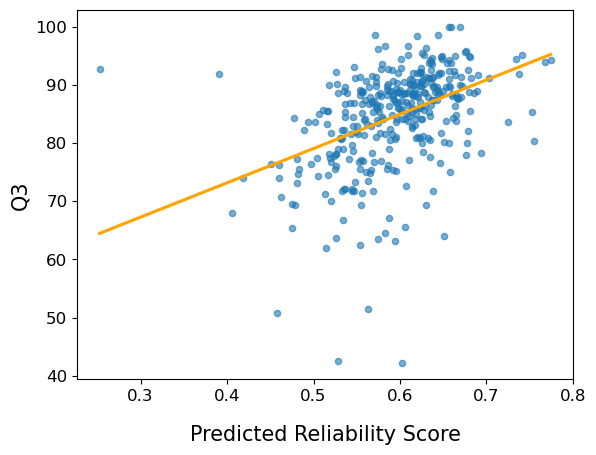

In [59]:
corr, pval = spearmanr(predictions["q3"], predictions["mlp_score"])

sns.regplot(x="mlp_score", y="q3", data=predictions, ci=None, scatter_kws={'alpha': 0.6, 's': 20}, line_kws={'color': 'orange'})
plt.xlabel("Predicted Reliability Score", fontsize=15, labelpad=15)
plt.ylabel("Q3", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

print(f"Spearman correlation: {corr:.4f} (p-value: {pval})")

Spearman correlation: 0.4689 (p-value: 0.0011581160579405513)


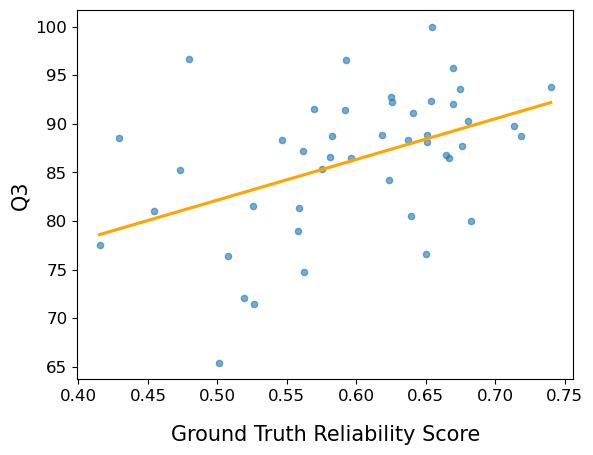

In [62]:
corr, pval = spearmanr(ground_truth["q3"], ground_truth["gt_reliability"])

sns.regplot(x="gt_reliability", y="q3", data=ground_truth, ci=None, scatter_kws={'alpha': 0.6, 's': 20}, line_kws={'color': 'orange'})
plt.xlabel("Ground Truth Reliability Score", fontsize=15, labelpad=15)
plt.ylabel("Q3", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

print(f"Spearman correlation: {corr:.4f} (p-value: {pval})")